# De Nardi (2004)

# [Wealth Inequality and Intergenerational Links](https://academic.oup.com/restud/article-abstract/71/3/743/1536436)

- Notebook created by [Ashish Kumar](https://github.com/ashishk87)

In this notebook, we  replicate and discuss the key findings of the referenced paper.  I would like to express my gratitude to Professor Chris Carroll for his valuable comments, guidance, and encouragement throughout this project.




Please visit this [page](https://computationalthinking.mit.edu/Spring21/installation/) to learn how to install Julia and then install pacakages.

In [5]:
using Distributions, JLD2, Plots, Interpolations, UnPack, Random, LinearAlgebra, DelimitedFiles, IJulia

#=
Functions that give us age specific policy function using value function iteration, updating the transition matrix and bequest distribution, 
along with several primitive functions which are used for interpolation are stored in the  tools.jl file to avoid clutter. We load all of them 
which will be used in the code below.
=#
include("tools_DeNardi_replication.jl")


transfer_wealth_ratio (generic function with 1 method)

The paper constructs a quantitative, general equilibrium, overlapping-generations model. The model links parents and children through voluntary and accidental bequests and the transmission of earnings ability. Key findings include:

- Voluntary Bequests: These explain the emergence of large estates and contribute significantly to wealth concentration.
- Earnings Persistence: Inherited earnings ability increases wealth concentration.
- Model Calibration: The model matches observed wealth distribution and saving behavior, showing higher savings rates for wealthy households.
- Bequest Motive: Essential for generating realistic lifetime saving profiles and explaining large estates at the top wealth distribution.

The recursive representation of the baseline model for different age groups is outlined below:

1. From age t = 1 to age t = 3 (20 to 30 yrs of age): Agent works and survive for sure until the next period. And there is no possibility of receiving the bequests since their parents are younger than than 60, and they'll survive atleast one more period for sure. Therefore:

$$
\begin{align*}
&V(t, a, y, yp) = \max_{c, a'} \left\{ u(c) + \beta\mathbf{E_{t}}V(t+1, a', y', yp) \right\}\\
&\text{s.t.c.}\\
& c \leq \left[1 + r(1 - \tau_a)a\right]  +  (1 - \tau_l)\epsilon_{t}y \\
& a' = \left[1 + r(1 - \tau_a)a\right] - c +  (1 - \tau_l)\epsilon_{t}y \\
\end{align*}
$$

where state variables of the problem are: $x = (t, a, y, yp)$, namely agent's age (t), agent's past savings (a), the current period productivity draw of the agent (y), and the value of the agent's parent's productivity at age 40 until the agent inherits and 0 thereafter (yp). In particular, every agent forms expectatioons on the bequest distribution by looking at their parent's productivity when they were of 40 years old, hence yp is a state variable of the problem until agent receives bequest, and after which yp = 0 correspond to the fact that parents are dead and agent has already received bequest in the past.

2. From age t = 4, to t = 8 (from 35 to 55 yrs of age): Agent works and survive for sure until the next period. However, agent's parents atre atleast 60 yrs old and face positive probability of dying next period, therefore agents might receive bequests at the beginning of next period.

$$
\begin{split}
V(t, a, y, yp) = & \max_{c, a'} \left\{ u(c) + \beta \mathbf{E_t}\left[V(t+1, a', y', yp')\right] \right\}\\
\text{s.t.}\ & \\
& c \leq \left[1 + r(1 - \tau_a)a\right]  +  (1 - \tau_l)\epsilon_{t}y \\
& a' = \left[1 + r(1 - \tau_a)\right]a - c + (1 - \tau_l)\epsilon_{t}y + b'I_{yp > 0}I_{yp' = 0}, \\
& yp' = \begin{cases}
yp & \text{with prob } s_{t+5}, \\
0 & \text{with prob } (1 - s_{t+5})\\
\end{cases}
\end{split}
$$

3. For age t = 9 (60 yrs old): Agent works and is retiring next period but now he faces a positive probability of dying next period in which case agent derrives utility from bequeathing assets,while other things remain identical to previous case.

$$
\begin{split}
V(t, a, y, yp) = & \max_{c, a'} \left\{ u(c) + \beta s_t\mathbf{E_t}\left[W(t+1, a') + (1 - s_t)\phi(b(a'))\right] \right\}\\
\text{s.t.} & \\
& c \leq \left[1 + r(1 - \tau_a)a\right]  +  (1 - \tau_l)\epsilon_{t}y \\
& a' = \left[1 + r(1 - \tau_a)\right]a - c + (1 - \tau_l)\epsilon_{t}y + b'I_{yp > 0}I_{yp' = 0}, \\
& yp' = \begin{cases}
yp & \text{with prob } s_{t+5}, \\
0 & \text{with prob } (1 - s_{t+5})\end{cases}\\
& \phi(b) = \phi_{1}\left(1 + \frac{b}{\phi_2} \right)^{1 - \sigma}\\
& b(a') = a' - \tau_{b}. max(0, a' - ex_{b})\\
\end{split}
$$

4. From age 10 to 14 (from 65 to 85 yrs of age): Agent is retired, and his parents are already dead, so no further possibility of bequests. DFuring retirement agents receive pension. 

$$
\begin{split}
W(t, a) = & \max_{c, a'} \left\{ u(c) + \beta s_t W(t+1, a') +  (1 - s_t)\phi(b(a')) \right\}\\
&\text{s.t.c.}\\
& c \leq \left[1 + r(1 - \tau_a)a\right]  +  p \\
& a' = \left[1 + r(1 - \tau_a)a\right] - c + p \\
& \phi(b) = \phi_{1}\left(1 + \frac{b}{\phi_2} \right)^{1 - \sigma}\\
& b(a') = a' - \tau_{b}. max(0, a' - ex_{b})\\
\end{split}
$$

The terminal period value function W(T+1, a) is set to equal $\phi(b(a))$.

Lastly, I use the same parameter values that were used in the paper. Please refer to the paper to understand the calibration strategy of the paper.




In [21]:
# Defining parameters for the model

# 1: Defining a parameter dictionary for the model

function params_dict(;tlength=5, dage=5, dy = 4, def = 45, TL = 9,
    dsur = 65, T = 14, TR = T-TL, 
    β = (0.95)^tlength, σ = 1.5, ϕ₁ = -9.5,ϕ₂ = 11.6, γ = 0.85, hbet = 0.67,
    τₐ = 0.2, τ_b = 0.1, 
    # exb = 8.5, 
    ggovt = 0.18, pens = 0.4,
    maxa = 50.0, mina = 0.0, da = 120, minc = 0.0, maxc = 1.0,
    σ_z = sqrt(0.3), σ_h = sqrt(0.37), 
    y = [0.2594, 0.6513, 1.5355, 3.8547],
    Qy = [0.7132 0.2764 0.0104 0.0; 0.1467 0.6268 0.2210 0.0055; 0.0055 0.2210 0.6268 0.1467; 0.0 0.0104 0.2764 0.7132],
    Qyh = [0.5257 0.4228 0.0509 0.0007; 0.1461 0.5538 0.2825 0.0176; 0.0176 0.2825 0.5538 0.1461; 0.0007 0.0509 0.4228 0.5257],
    # y = [0.3272188, 1.000000, 3.056059],
    # Qy = [0.7490493      0.2460441      4.9065556E-03;0.1650564       0.6698872  0.1650564; 4.9065561E-03    0.2460441   0.7490494],
    # Qyh = [0.6421676      0.3458525      1.1979862e-02; 0.1682615      0.6634769   0.1682615; 1.1979862E-02  0.3458525      0.6421676],
    prod_inher = true, vol_beq = true)
    """
    tlength: length of the time period
    dage: parent-child age difference
    dy: no. of income 
    def: size of eflife (which is age-efficiency profile for workers)
    TL = def/tlength: No. of working periods
    dsur = 65 # alive fro, 20 to 65
    T = 14 # Max no. of periods alive (dsur/tlength + 1)
    TR = T-TL # No. of retirement periods

    # Preferences
    σ = 1.5 # risk aversion
    β = (0.9455)^tlength # discount factor
    ϕ₁ = -9.5 # joy of bequeathing parameter 1
    ϕ₂ = 8.0 # joy of bequeathing parameter 2
    γ = income autoregressive coefficient
    hbet: inheritance autoregressive coefficient
    gpop: population growth rate 0.05773918371694153

    # Government and tech
    r: exogenous interest rate (ensures annual K/Y = 3)
    τₐ: tax rate on capital income
    τ_b: tax rate on bequests
    exb: years avg earn for estate taxes exempt
    ggovt.: government expenditure
    pensions: repl rate*avg income
    δ: depreciation rate (6% yearly)

    # Grids
    maxa: maximum level of capital
    mina: minimum level of capital
    da = dar: No. of  points on asset grid
    dc: No. of points on consumption grid
    minc: minimum cons proprtion 
    maxc: maximum cons proportion

    # Income process
    σ_z: standard deviation of income shocks
    σ_h: std deviation of inheritance shocks

    # The values for the following three objects are directly taken from the paper
    y: 4-state productivity grid (values taken from the appendix of the paper)
    Qy: transition matrix for y (values taken from the appendix of the paper)
    Qyh: inheritance transition matrices (values taken from the appendix of the paper)
    Qher: productivity transmission matrix for a 20 yr old parent to a 20 yr old child
    invher: invariant distribution of productivity at birth
    inv40: invariant distribution of productivity at 40 years of age 
    jt4020: joint distribution of parents productivity at 40 years of age and kids productivity at 20 years of age
    eff: age-efficiency profile for workers from 20 to 65 based on the elflife.dat file and tailored to then period length of 5 years
    sur: survival probabilities from age 20 to 90
    csur: cumulative survival probabilities
    numch: per capita number of children

    """
    # Set a Random seed
    Random.seed!(2022)


    gpop = (1.012)^tlength
    r = 1.06^tlength - 1
    δ = 1 - (0.94)^tlength
    dc = da


    #=
    ! matrix Qyh: inheritance of y: 40 years old parent-20 years old child
    ! want transmission  matrix Qher:
    ! 20 years old parent- her future 20 years old child
    ! (because want the invariant distribution at birth of these characterstics in population)
    ! have: c_20'=p_40'*Qyh, (i.e. children at 20 gets assigned what parents are at 40 times the inheritance transmission matrix) 
    ! We can rewrite the above as:
    ! c_20'=p_35'*Qy*Qyh, as p_40'=p_35'*Qy. (i.e. parents at 40 gets assigned what parents are at 35 times the income transmission matrix)
    ! Keep doing it recursively until we get the following
    =#
    Qher = Qy * Qy * Qy * Qy * Qyh
    # Compute the eigenvalues and eigenvectors of the transpose of Qher
    eig = eigen(Qher')
    #Extract the principal eigenvalue and eigenvector
    EVAL = eig.values
    EVEC = eig.vectors
    # Sort eigenvalues in decreasing order and rearrange eigenvectors accordingly
    sorted_indices = sortperm(EVAL, rev=true)
    EVAL = EVAL[sorted_indices]
    EVEC = EVEC[:, sorted_indices]
    # Check the conditions
    if (abs(real(EVAL[1]) - 1) > 1e-4) || (abs(real(EVAL[2] - 1)) < 1e-4)
        error("problems with Qy")
    end
    eigval = real(EVAL[1])
    eigvec = real.(EVEC[:, 1])

    # invher is the stationary distribution of productivity at age 20 when productivity inheritance is operational
    invher = eigvec ./ sum(eigvec)
    # distribution of characterstics at 40 years of age:  multiply Qy 4 times coz it gets from age 20 to 40 (20 ->25 ->30 ->35 ->40) and inverh is the invariant distribution of characterstics at age 20
    inv40 = (invher'*Qy*Qy*Qy*Qy)'


    # Calculate the joint distribution for parent's characterstics at age 40 and children's characterstics at age 20.
    #=
    So, (i, j)th entry of jt4020 is the distribution that the parent at age 40 is in the i-th income state and the child at age 20 is in the j-th income state.
    =#

    #=
    In secion 4 of the paper, the author mentions the following:

    "To be consistent across experiments, I use the same initial distribution of productivity for 20 yr old workers in all simulations.
     To do so, I compute the initial aggregate distribution of productivity implied by the experiment with inheritance of productivity 
     and use it to initialize all the 20-year-old workers in the simulations without productivity inheritance"

    invher is the initial aggregate distribution of productivity implied by the experiment with inheritance of productivity.
    - With productivity inheritance we use invher and Qy to get to the stationary distribution of productivity at age 40 (inv40 = Qy*Qy*Qy*Qy*invher).
      And then use inv40 and Qyh to get the joint distribution of parents productivity at 40 and kids productivity at 20 (jt4020).
    
    - Without productivity inheritance, we start with invher and use (Qy)⁴  to get the joint distribution of parents productivity at 40 and kids productivity at 20 (jt4020),
       rather than using inv40 and Qyh.
    =#

    jt4020 = zeros(dy, dy)
    Q_y_20_to_40 = Qy^4
    if prod_inher
        for i in 1:dy
            for j in 1:dy
                jt4020[i, j] = Qyh[i, j] * inv40[i]
            end
        end
    else
        jt4020  = inv40*invher'
    end



    #=
    Construct the conditional survival probability from age 20 to 90
    =#
    # Read survival probabilities from file
    surlife = readdlm("output/surlife.dat")
    # Process survival probabilities
    sur = ones(T) # Initialize survival probabilities
    for i in 1:tlength:dsur
        sur[(i-1)÷tlength + 1] = prod(surlife[i:i+tlength-1])
    end

    # Adjustments for early ages
    sur[1:8] .= 1.0
    sur[end] = 0.0 

    # Cumulative survival probabilities
    csur = ones(T + 4)
    csur[5:end] = sur
    for i in 5:T+4
        csur[i] = prod(sur[1:i-4])
    end


    # age productivity transition matrix. For ex. (1, dy+1) entry of this matrix gives the prob. of moving from age
    # 1 and productivity 1 to age 2 and productivity 1, (1, dy+2) gives the prob. of moving from age 1 and productivity 1 to age 2 and productivity 2, and so on.
    EM = zeros(TL*dy,TL*dy) 
    eq, eminv, eminv1 = [zeros(TL*dy) for _ in 1:3]
    for i in 1:TL-1 # loop over today's age
        for j in 1:dy # loop over productivity
            EM[(i-1)*dy + j, dy + (i-1)*dy + 1: dy + i*dy] = sur[i]*Qy[j,:]
        end
    end
    # Now computing the invariant distribution of age-productivity
    eq[1:dy] = invher
    eminv = eq
    ϵ = 1.0
    while ϵ > 1e-8
        eminv1 = eminv
        eminv = (EM'*eminv)/gpop .+ eq
        ϵ = maximum(abs.(eminv - eminv1))
    end
    eminv = eminv./sum(eminv)

    #=
    Form a matrix with age on the rows and productivity on the columns. Every cell contains 
    the no. of people in each cell in order to compute the age-efficiency profile implied by 
    the income process.
    =#
    ageyn = zeros(TL,dy)
    ageyn .= transpose(reshape(eminv, dy, TL))
    # transform the matrix in terms of fraction of people of a given age
    for i in 1:TL 
        ageyn[i,:] = ageyn[i,:]./sum(ageyn[i,:])
    end
    # compute the avg. age productivity profile implied by income process
    endeff = zeros(TL)
    endeff = ageyn*y

    #= Construct age-efficiency profile for workers: from 20 to 65
    I use the elflife.dat file that author provided to construct this object
    =#
    # ! construct age-efficiency profile for workers
    #Reading data from a file
    # Open and read the 'eflife.dat' file: 
    """
    Replace the directory as per your location
    """
    eflife = readdlm("output/eflife.dat")
    # Initialize the efficiency array
    eff = zeros(Float64, ceil(Int, length(eflife) / tlength))

    # Transform yearly age-efficiency profile according to the period length
    for i in 1:tlength:def
        eff[(i-1)÷tlength + 1] = sum(eflife[i:i+tlength-1])
    end

    # Normalize the efficiency profile
    eff = (eff *TL)/sum(eff)
    eff = eff ./ endeff

    #! Experiment
    # Surv prob.
    sur1, pfrac = [zeros(T)  for _ in 1:2]
    sur1[1] = 1.0
    sur1[2:T] = sur[1:T-1]
    for i in 1:T
        pfrac[i] = prod((sur1[1:i] ./ gpop))
    end

    pfrac = pfrac./sum(pfrac)
    aveinc = sum(pfrac[1:TL].*eff.*endeff)

    exb = 8*aveinc # 40 yrs of avg. earnings
    #

    # Compute per capita number of children-Same as in DeNardi (2002)
    # That is done as follows:
    # newbornsₜ₊₁ = gpop*newbornsₜ - (1) Population law of motion
    # newbornsₜ = numch*parentsₜ - (2) (numch is the per capita number of children), and therefore (2) gives us total number of children
    # parentsₜ = newborns_{t-dage}*sur[1] - (3) {No. of parents at 25 equals the number of newborns at 20 times the survival probability from 20 to 25 (one until they are 20 and sur[1] b/w 20 and 25)}
    # Using (2) and (3): newbornsₜ = numch*newborns_{t-dage}*sur[1] - (4)
    # Using (1): newbornsₜ = gpop*newbornsₜ₋₁
    #                     = (gpop)^2*newbornsₜ₋₂
    #...                  = (gpop)^(dage)*newborns_{t-dage} - (5)
    # Using (4) and (5): numch = (gpop)^dage/sur[1] - (6)
    numch = gpop^dage/sur[1]

    # Asset Grid
    agrid = range(mina, sqrt(maxa), length=da)
    agrid = agrid.^2

    # Asset Grid Net of Estate taxes
    anet = zeros(size(agrid))
    anet .= ifelse.(agrid .<= exb, agrid / numch, (agrid .- τ_b .* (agrid .- exb)) / numch)

    # Consumption Grid
    cgrid = collect(range(minc, maxc, length=dc+1))

    # Warm-Glow utility from net bequests-grid over all possible bequests levels
    ϕ = zeros(size(agrid))
    # ϕ1 = zeros(size(agrid))
    wg = zeros(size(agrid))
    if vol_beq
        # wg .= ((1 .+ (agrid .- τ_b.*max.(agrid .- exb, zeros(size(agrid))))./ ϕ₂).^(1 - σ) .- 1).*ϕ₁ 
        # ϕ1 .= [(1 + (a - τ_b * max(a - exb, 0.0)) /ϕ₂)^(1 - σ) - 1 for a in agrid] .* ϕ₁
        ϕ .=((1 .+ (agrid .- τ_b.*max.(agrid .- exb, 0.0 .* agrid))./ϕ₂).^(1-σ) .- 1).*ϕ₁
    else
        ϕ .= 0.0
    end


    return Dict(:tlength => tlength, :dage => dage, :dy => dy, :def => def, :TL => TL, :dsur => dsur, :T => T, :TR => TR,
    :β => β ,:σ => σ, :ϕ₁ => ϕ₁, :ϕ₂ => ϕ₂, :γ => γ, :hbet => hbet, :τₐ => τₐ, :τ_b => τ_b, :exb => exb, :ggovt => ggovt, :pens => pens,
    :maxa => maxa, :mina => mina, :da => da, :minc => minc, :maxc => maxc, :dc => dc, :r => r, :δ => δ, :gpop => gpop, :σ_z => σ_z, :σ_h => σ_h,
    :y => y, :Qy => Qy, :Qyh => Qyh, :Qher => Qher, :invher => invher, :inv40 => inv40, :jt4020 => jt4020, :eff => eff, :sur => sur, :csur => csur, :numch => numch,
    :agrid => agrid, :anet => anet, :cgrid => cgrid, :ϕ => ϕ)

end

params = params_dict();

All of the model's parameters are contained in the disctionary named `params` which we can pass to our main function. The main function makes use of host of primitive functions defined in `tools.jl` file that we imported before. So, readers should refer to that file in case they are interested in understanding the specific details of those functions.

In [22]:
# Main function that solves the model and solves the model and stores the results in a dictionary

function denardi_main(params; τ_l = 0.2823769, beqdist = nothing, kercoeff = nothing)
    """
    This function solves and simulates the model in a general equilibrium
    """

    # Unpacking parameters
    @unpack tlength, dage, dy, def, TL, dsur, T, TR, β ,σ, ϕ₁, ϕ₂, γ, hbet, τₐ, τ_b, exb, ggovt, pens, 
    maxa, mina, da, minc, maxc, dc, r, δ, gpop, σ_z, σ_h, y, Qy, Qyh, Qher, invher, inv40, jt4020, 
    eff, sur, csur, numch, agrid, anet, cgrid, ϕ = params


    # Set a Random seed
    Random.seed!(2022)

    # Initializing objects such as the value function, policy functions, etc.

    #=
    distribution of bequests:
    -Bequests in this model depends on ageent's age (can inheirt upto first year of retirement)
    and on her parents productivity level at age 40.
    -Agents do not die until they are 60, so their kids can't inherit unitl they are 40.
    - beqdist contains bequest distribution gross of estate taxes
    =#
    if beqdist == nothing
        beqdist = zeros(da, dy, TL-3) 
        beqdist[1, :, :] .= 1  # initialization
    else
        beqdist = beqdist
    end

    #=
    Value function for retirees:
    -state 1: cash at hand
    -state 2: age
    =#
    vr = zeros(da, TR+1)
    # Setting the last period's value fn to the value of joy of bequeathing for that period (since agent will be dead for sure by then)
    # DeNardi (2002) assumes parents gets joy of bequeathing on net bequests
    vr[ :, TR+1] .= ϕ

    #=
    Policy function for the retirees:
    -state 1: market resources at hand
    -state 2: age
    =#
    # polr = zeros(da, TR+1)  # Check again
    polr = zeros(da, TR)

    #=
    Value function and policy fn for working people:
        -state1: cash at hand
        -state2: productivity
        -state3: parents productivity at age 40 (expectations of bequests and inheritance shape up the optimal consumption decisions)
                 (parents might be dead, so extra state added to the state space)
        -state4: age
    =#
    vt = zeros(da, dy, (dy+1), TL)
    polt = zeros(Int, da, dy, (dy+1), TL)
    # weights assigned to the left grid point next to the optimal savings choice
    w_assets = zeros(da, dy, (dy+1), TL) 
    polc = zeros(da, dy, (dy+1), TL)

    #=
    Optimal savings policy function for the retirees:
        -When agent can inherit, there's a prob. dist. on next peiod's assets linked to the relevant
        prob dist on bequests
    =#
    sopt = zeros(da, dy, (dy+1) ,TL)

    # Some other objects
    agew = zeros(da, T) # assets at age t for t = 1, 2, ..., T-1
    agewT = zeros(da) # assets at age T
    beqtax=0.0
    aveinc = 0.0
    numret = 0.0
    gbal = 0.0
    dista = zeros(da)
    avgk = 0.0
    indnoh = dy*dy*da*4 
    indret = 4*dy*dy*da + 5*dy*(dy+1)*da  
    counterbeq = 0.0


    #=
    Initializing the vector of newborns, i.e. their distribution across the state-space using the invariant distribution of productivity at birth inherited from parents.
    Since no parent die before 60, no child inherits before 40, so all newborns start off from zero wealth.

    This object changes during the experiment when there is no productivity inheritance. 
    Instead of doing this, we set qinit to be equal to the stationary distribution over income states for 20 year olds (see eminv)
    =#
    qinit = zeros(dy*dy*da)
    for i in 1:dy
        for j in 1:dy
            qinit[(i-1)*da*dy + (j-1)*da + 1] = jt4020[i, j]
        end
    end

    # Initializing invariant distribution
    #=
    # total no. of states:
      1) 4*dy*dy*da: total no. of states for working people when young and parents definitely survive next period. ∴ (#age)*(#productivity)*(#parents productivity)*(#asset)
      2) 5*dy*(dy+1)*da: total no. of states for working people when young and parents might die next period. ∴ (#age)*(#productivity)*(#parents productivity)*(#asset)
      3) 5*da: total no. of states for retirees. ∴ (#age)*(#asset)
    =#
    ninvm = 4*dy*dy*da + 5*dy*(dy+1)*da + 5*da 
    invm = zeros(ninvm)

    # Kernels to smooth the bequest distribution. Will be used later on.
    numkernel = 31
    kernelfun = zeros(da, numkernel)
    kernelreg = zeros(numkernel, da)
    kernel_smooth!(params, numkernel ,kernelfun, kernelreg)


    # Arrays to store smooth bequest distribution
    if kercoeff == nothing
        kercoeff, kercoeff2 = [zeros(numkernel, dy, TL-3) for _ in 1:2]
    else
        kercoeff = kercoeff  # To run the experiment: time it takes to run the func with the right guess of bequest dist.
        kercoeff2 = kercoeff
    end

    #=
    Solve the value fn of retirees:
    - Retirees have already received bequests and are not going to work anymore.
    - They do not pay labor income taxes.
    - So, the state variable is just the cash at hand, and their age.
    =#
    vfi_retirees!(params, vr, polr)



    #=
    Now we fill the transition matrix (M) for the retirees:
    - M is a sparse matrix with the following structure:
    - rowindex of the transition matrix is given by rowM[counter]
    - colindex of the transition matrix is given by colM[counter]
    - value of the transition matrix is given by valM[counter]
    - counter track the states. Since optimal savings can lie between two grid points, we need to keep track of the weights assigned to the left grid point next to the optimal savings choice. So, for any given state s to any other state s', there will be two counter values attached to this one transition coz of the two grid points involved.

    here counter is is the unique identifier of each cell in the transition matrix
    =#
    
    #=
    We begin by specifying the nonzero elements in the transition matrix.
    And that is nonzeroM. Logic?

    Take the first component (da*dy*dy*3)*(dy).
    - da*dy*dy*3: total no. of states for working people when young and parents definitely survive next period. ∴ (#age)*(#productivity)*(#parents productivity)*(#asset)
    - Next period agents productivity can change, and so there are dy possible states for the next period's productivity.
    - Agents assets next period are determined by optimal policy, so it can transition to only one specific asset state.
    - Agent gets older by 1 year, so his age transitions to a deterministic next period age.
    - Since agent forms expectations of bequests based on parents productivity at age 40 which remains same even next period.
    - So, in total there are dy possible transition from any of the da*dy*dy*3 current states. 
    - Therefore, there are da*dy*dy*3*dy nonzero elements for the young working people when parents definitely survive next period.

    Similarly other components of the nonzeroM can be interpreted.
    =#
    nonzeroM =  (da*dy*dy*3)*(dy*2)+(da*dy*dy)*(dy*2+dy*da)+ 
                (da*dy*dy*4)*(dy*2+dy*da)+(da*dy*4)*(dy*2)+ 
                (da*dy*dy)*da+(da*dy)*2+(da*4)*2 

    # println(nonzeroM) # 4978080
    
    
    #=
     Starting row index for the retirees. This is the last row index of the working people.
     Can also be thought of as the total no. of states for working people.
    =#
    indret = 4*dy*dy*da + 5*dy*(dy+1)*da  

            
    rowM = zeros(Int, nonzeroM) # row index of the transition matrix
    colM = zeros(Int, nonzeroM) # column index of the transition matrix
    valM = zeros(nonzeroM) # value of the transition matrix corresponding to the row and column index

    # counter for the nonzero elements in the transition matrix.
    counter = Ref(1)

    # Update the part of transition matrix for retirees
    transition_retirees!(params, polr, indret, rowM, colM, valM, counter)


    #=
     # total no. of non zero entries in the transition matrix of the oldies
     da: the no. of states of cash-on-hand
     # And they die next period for sure, and next period savings are given by policy function, so transition to next state is deteministic.
     # Therefore, there are da nonzero elements for the oldies.
    =#
    nonzeroMT = da
    rowMT = zeros(Int, nonzeroMT) # row index of the transition matrix for oldies
    colMT = zeros(Int, nonzeroMT) # column index of the transition matrix for oldies
    valMT = zeros(nonzeroMT) # value of the transition matrix for oldies
    counter2 = Ref(1)
    # Update the transition matrix for the oldies (this is seperate matrix MT which is dfferent from M which is for the retirees and working people)
    transition_oldies!(params, polr, rowMT, colMT, valMT, counter2)

    #=
    Now we solve the value function and policy function for the working people (continuing the backward induction)
    And fill the part of the transition matrix for the working people.

    Some important points:
    - Working people can only receive bequests after they turn 40 so they form expectations of bequests and inheritance. So, we'll have to keep track of the entire bequest distribution.
    - Also the budget constraint of the govt. needs to be satisfied. So, adjust τ_l until it does.
    =#

    # τ_l = 0.19671993190545248 # initial guess for labor income tax rate
    # τ_l = 0.2823769  # initial guess for labor income tax rate
    relax = 0.7 # relaxation parameter for updating τ_l
    ϵ₂ = 1.0 # tolerance for govt. budget constraint
    # # counter for the nonzero elements in the transition matrix.
    # counter = Ref(4*da + 1)

    while ϵ₂ > 1e-4 # loop until govt. budget constraint is satisfied
        counterbeq = 1.0

        # Iterating over bequest distribution
        ϵ₁ = 1.0 # tolerance for convergence of bequest distribution

        while (ϵ₁ > 1e-4) # loop until convergence of bequest distribution
            iter = 1
            # # Store the hours, minutes and seconds before the iteration in a log file
            # current_time = Time(now())
            # # Extract hour, minute, and second
            # IHOUR = hour(current_time)
            # IMIN = minute(current_time)
            # ISEC = second(current_time)

            # # Open the log file in append mode
            # open("time_log.txt", "a") do file
            #     # Write the values to the file
            #     write(file, "Started at $IHOUR $IMIN $ISEC\n")
            # end

            "
            First we compute the value and policy function of all workers and then we will compute the transition matrix for the working people.
            We divide this task in cases.


            Case-1: Workers age TL (i.e. age 60). They are going to retire next period.
                    Currently the state space is ( parents productivity, own productivity, cash at hand).
                    Within this case there are two sub-cases.

                Case-1.1: Workers who have already inherited
                    - They have already received bequests so don't track beq dist. anymore
                
                Case-1.2: Workers who did not inherit so far but will definitely inherit next period
                    - This case requires tracking the bequest distribution

            The following function updates the value function, policy function for this case.
            "
            vfi_workers_1!(params,τ_l, vr, polt, polc, w_assets, vt, sopt, beqdist)

            "
            Now moving to next case:

            Case-2: Workers aged 55 to 35.
                - They receive income shock next period, so far that was not the case
                - They can inherit next period
                - But they cannot die next period, so they do not leave bequests next period
            "
            vfi_workers_2!(params, τ_l, polt, polc, w_assets,  vt, sopt, beqdist)

            "
            Now moving to last case:

            Case-3: Workers aged 20 to 30.
                - They receive income shocks
                - They cannot inherit next period
                - And they cannot die next period, so they do not leave bequests next period
            "
            vfi_workers_3!(params, τ_l, polt, polc, w_assets,  vt, sopt, beqdist)

            # # Store the hours, minutes and seconds before the iteration in a log file
            # current_time = Time(now())
            # # Extract hour, minute, and second
            # IHOUR = hour(current_time)
            # IMIN = minute(current_time)
            # ISEC = second(current_time)

            # # Open the log file in append mode
            # open("time_log.txt", "a") do file
            #     # Write the values to the file
            #     write(file, "val fun computed at $IHOUR $IMIN $ISEC\n")
            # end

            #=
            Computed the value function and policy function for all workers. Now we need to update the transition matrix for the working people.

            Important points to note: Agents die and born each period, so rows of the transition matrix do not sum to 1 (people that die disappear from the system, and at each period a new cohort is born).
            The people's distribution over the state variables evolve accoding to:
            nₜ₊₁ = nₜ'M + qₜ₊₁ , where nₜ is the distribution of people over the state variables at time t and qₜ₊₁ is the distribution of newborns at time t+1.

            How is matrix M structured?
             - 1st variable: Agent's age
             - 2nd variable: Parent's productivity
             - 3rd variable: Agent's productivity
             - 4th variable: Agent's assets

            Before retirement, all four constitute the state space. After retirement, only age and assets constitute the state space coz they don't work and ca't inherit anymore.

            We filled in the transition matrix for the retirees and the oldies who are going to die for sure next period. Now we fill in the transition matrix for the working people now.
            =#

            rowM[4*da*2 + 1:end] .= 0
            colM[4*da*2 + 1:end] .= 0
            valM[4*da*2 + 1:end] .= 0

            # # counter for the nonzero elements in the transition matrix.
            counter = Ref(4*da*2 + 1)

            # Starting row index for the people too young to have inherited
            indnoh = dy*dy*da*4 
            
            # turn all entries in w_assets to be positive
            w_assets .= abs.(w_assets)

            "
            Case-1: Transition matrix for working people who've already inherited but are not retiring next period.
                    - In the model, the earliest an agent inherits is when he's 40 yr
            "
            transition_workers_1!(params,indnoh, polt, w_assets, rowM, colM, valM, counter)

            "
            Case-2: Transition matrix for working people that have already inherited and are retiring next period.
            "
            transition_workers_2!(params,indnoh, indret, polt, w_assets, rowM, colM, valM, counter)

            "
            Case-3: Transition matrix for working people who have not inherited so far and who do not inherit next period.
                    Age 20 to 35 included
            "
            # Case-3.1: Age 20 to 35 included
            transition_workers_3_1!(params, polt, w_assets, rowM, colM, valM, counter)
            # Case-3.2: Age 40 to 55 included
            transition_workers_3_2!(params, indnoh ,polt, w_assets, rowM, colM, valM, counter)

            "
            Case-4: Working people that have not inherited but will do so next period
            "
            # Case-4.1: Age 35 (or model age 4)
            transition_workers_4_1!(params, indnoh, sopt, rowM, colM, valM, counter, beqdist)
            # Case-4.2: Working people that inherit but are not retiring next period (age 40 to 55)
            transition_workers_4_2!(params, indnoh, sopt, rowM, colM, valM, counter, beqdist)
            # Case-4.3: Working people that inherit and are retiring next period (age 60)
            transition_workers_4_3!(params, indnoh, indret, sopt, rowM, colM, valM, counter,beqdist)


            "
            Now we have the transition matrix for the working people. We can now compute the invariant distribution of the state variables.
            "
            q = zeros(dy*dy*da)
            q .= qinit
            invm1 = similar(invm)
            invm1 .= 0.0
            err = 1.0
            while err > 1e-8
                invm1 .= invm
                invm .= 0.0

                # The following for loop is the product M'*invm. Since, M is a sparse
                # matrix, to transpose M, swe simply use colM instead of rowM.
                # invm = updated distribution
                # invm1 = old distribution
                for i in 1:nonzeroM
                    invm[colM[i]] = invm[colM[i]] + (invm1[rowM[i]]*valM[i])/gpop 
                end

                invm[1:dy*dy*da] = invm[1:dy*dy*da] +  q
                err = maximum(abs, invm - invm1)
            end

            invm .= abs.(invm) ./ sum(abs.(invm))
            q .= q./sum(q)

            # Check if invm has any NaN values
            if any(isnan, invm)
                println("invm has NaN values")
                println(sum(invm))
            end

            # Now updating the bequest distribution
            beqdist .= 0

            #=
            DeNardi(2002) assumes that children observes parents productivity at age 40 before enetering job market (i.e. at age 15).
            Therefore, the ebquest distribution will be conditional on the parents productivity at age 40: beqdist(a |yp40, t).
            To construct this object, we go through several steps:

            Step-1: Find the distribution of assets at 40 yrs of age (Since we are dealing with stationary distribution, we can use the invariant distribution of assets at 40 yrs of age.)
                    Note that the above distrution will depend on parents productivity as well as their parents productivity (kid's grandparents) at age 40.
            =#

            # The following is the joint distribution of agent's income, his parents income (also at age 40), and his assets at age 40.
            temprealv2 = zeros(da*dy*(dy+1))
            temprealv2 = invm[4*dy*dy*da + 1:4*dy*dy*da + dy*(dy+1)*da] 

            # Using the above object, we will construct the conditional distribution of assets at 40 yrs of age given parents productivity at 40 yrs of age.
            #=
            Step-1 Contd: Construct joint distribution of agents parents income at 40, and agents assets at 40 conditional on his income at 40.
                          P(yp = ypⱼ, a = aₖ|y = yᵢ) = P(yp = ypⱼ, a = aₖ, y = yᵢ)/P(y = yᵢ) - (*)
                          where:
                          P(y = yᵢ) = ∑ⱼₖ P(yp = ypⱼ, a = aₖ, y = yᵢ)
            =#
            temprealv = similar(temprealv2)
            temprealv .= 0.0

            temprealv4 = zeros(dy) # marginal (stationary) distribution of income at 40 yrs of age

            # First we construct P(y = yᵢ) by summing over all possible values of yp and a
            # To construct the marginal of agents income at 40 integrate out it from the joint distribution-temprealv2. 
            # That is what the following block is doing.
            for i in 1:dy # loop over agents income at 40
                for j in 1:dy+1 # loop over grandparents income at 40 (might be dead)
                    for k in 1:da # loop over agents assets at 40
                        temprealv4[i] = temprealv4[i] +  temprealv2[(j-1)*(dy)*da + (i-1)*da + k]
                    end
                end
            end

            # Next, we construct P(yp = ypⱼ, a = aₖ|y = yᵢ) since we already have the numerator and denominator from (*)
            for j in 1:dy+1 # loop over agents income at 40
                for k in 1:da # loop over grandparents income at 40 (might be dead)
                    for i in 1:dy # loop over agents assets at 40
                        temprealv[(j-1)*dy*da + (i-1)*da + k] = temprealv2[(j-1)*(dy)*da + (i-1)*da + k]/temprealv4[i]
                    end
                end
            end

            #=
            Step-2: Next we construct the conditional distribution of characterstics of agents at 40 conditional on their income- m(a, y40, yp40|y40)
                    Coz that is what kids use to form expectations of bequest distribution. And we iterate that object forward in time using the
                    transition matrix M, i.e. m(a', y45, yp40|y40) = m(a, y40, yp40|y40)*M
                                              m(a'', y50, yp40|y40) = m(a', y45, yp40|y40)*M and so on.
            =#
            stbeq = zeros(da*dy*(dy+1), dy) #  column i of this object will contain the conditional distribution corresponding to income level i from temprealv.   

            for i in 1:dy # loop over agents income at 40 (parents income at 40)
                for jj in 1:(dy+1) # productivity of grandparent (might be dead, so added 1 to dy)
                    stbeq[(jj-1)*da*dy .+ (i-1)*da .+ collect(1:da), i] = temprealv[(jj-1)*(dy)*da .+ (i-1)*da .+ collect(1:da)]
                end 
            end

            #=
            Now having constructed the conditional parents characterstics at age 40-m(a, y40, yp40|y40), we will use this object
            along with transition matrix to construct bequest distribution. Intuitively, we are just going to take dot product of 
            this period state with corresponding entry from transition matrix to obtain next period same distribution. And we will 
            continue to do it until we reach age 60 and beyond coz parents leave bequests after crossing age 60 (coz of mortality risk 
            they can leave bequest anytime after that).
            =#
            beq_dist_update_1!(params, indnoh, rowM, colM, valM, stbeq)

            #=
            So, now we have updated the conditional distribution of parents characterstics m(a, y40, yp40|y40) upto age 60.
            That's what previous block of the code was all about. Now we iterate this distribution one step ahead, i.e. when agents attain age 65.
            So, like the above block we consider two cases:
              (i) working that have already inherited
              (ii) people that have not yet inherited (but will inherit next period since everyone receive bequests by the time they retire)
            =#
            stbeqret = zeros(da, dy)
            beq_dist_update_2!(params, indnoh, indret, nonzeroM, rowM, colM, valM, stbeq, stbeqret)

            # The updated stbeqret serves as the bequest distribution if agents die aged 65 (right when they retire)
            beqdist[:, :, TL-dage-3] .= stbeqret

            #=
            So far, we've computed asset distribution of agents until they turn 65 (when they start facing mortality risk).
             Now we will further rollover this asset distribution further (age 70, 75, 80, 85) using relevant part of transition matrix.
            =#
            beq_dist_update_3!(params, indret, nonzeroMT, rowM, colM, valM, rowMT, colMT, valMT, stbeqret, beqdist)

            # Smooth bequest distribution with Kernels
            kercoeff2 .= kercoeff
            # beqdist2 = copy(beqdist)
            kercoeff .= 0.0
            for i in 1:TL-3
                kercoeff[ :, :, i] = kernelreg*beqdist[ :, :, i]
                beqdist[ :, :, i] = kernelfun*kercoeff[ :, :, i] 
            end

            # Set negative entries to zero
            beqdist[beqdist .< 0] .= 0.0

            # Normalize smoothed bequest distribution
            for i in 1:TL-3
                for jj in 1:dy
                    beqdist[:, jj, i] .= beqdist[:, jj, i]./sum(beqdist[:, jj, i])
                end
            end

            # # Save kercoeff and kercoeff2 in matrices
            # @save "kercoeff.jld2" kercoeff
            # @save "kercoeff2.jld2" kercoeff2

            ϵ₁ = maximum(abs, kercoeff - kercoeff2)
            # @info "ϵ₁: $ϵ₁"
            # @info "counterbeq: $counterbeq"
            counterbeq += 1
        end # end of while loop for convergence of bequest distribution

        # Store the hours, minutes and seconds before the iteration in a log file
        # current_time = Time(now())
        # Extract hour, minute, and second
        # IHOUR = hour(current_time)
        # IMIN = minute(current_time)
        # ISEC = second(current_time)

        # # Open the log file in append mode
        # open("time_log.txt", "a") do file
        #     # Write the values to the file
        #     write(file, "beqdist computed at $IHOUR $IMIN $ISEC\n")
        # end

        #=
        Compute the govt. budget constraint
        =#

        # First compute distribution over assets
        dista .= 0.0
        for i in 1:4*dy*dy + 5*(dy+1)*dy + 5  # sum people up
            dista .= dista .+ invm[(i-1)*da + 1:i*da]
        end

        # Avg k: multiply each asset level for no. of people owning it, working or retired
        avgk = sum(dista .* agrid)

        #=
        ! construct a matrix with assets on the rows and age on the columns
        !        age 1  age 2 ......age TL.....ageT
        !  a1
        !  a2
        !  ...
        !  ada
        =#
        agew = zeros(da, T) # assets at age t for t = 1, 2, ..., T-1
        agewT = zeros(da) # assets at age T
        indnoh = dy*dy*da*4
        indret = 4*dy*dy*da + 5*dy*(dy+1)*da
        asset_by_age!(params, invm, indnoh, indret, nonzeroMT, rowMT, colMT, valMT, agew, agewT)

        # Count no. of assets in agrid less than exb
        tempint1 = sum(agrid .< exb)
        beqtax = 0.0
        for i in tempint1+1:da 
            tempreal = τ_b*(agrid[i] - exb)
            for j in TL+1:T
                beqtax += tempreal * agew[i, j] * (1 - sur[j-1]) / sur[j-1]
            end
            # 90 yrs old
            beqtax += tempreal * agewT[i]
        end

        # Avg. income and num retirees
        aveinc, numret, pfrac = age_prod_inv_dist(params)

        # Now calculating govt. balance
        gbal = τₐ*r*avgk + τ_l*aveinc - pens*numret - ggovt*(aveinc + r*avgk) + beqtax
        # @info "avek: $avgk"
        # @info "gbal: $gbal"
        τ_l_2 = τ_l
        τ_l = τ_l - relax*(gbal/aveinc)
        ϵ₂ = abs(τ_l - τ_l_2)
        # @info "ϵ₂: $ϵ₂"
        # @info "τ_l: $τ_l"
        # @info "τ_l_2: $τ_l_2"
        # @info "gbal: $gbal"
        # @info "aveinc: $aveinc"


        
         
    end # end of while loop for govt. budget constraint

    # # Store the hours, minutes and seconds before the iteration in a log file
    # current_time = Time(now())
    # # Extract hour, minute, and second
    # IHOUR = hour(current_time)
    # IMIN = minute(current_time)
    # ISEC = second(current_time)

    # # Open the log file in append mode
    # open("time_log.txt", "a") do file
    #     # Write the values to the file
    #     write(file, "New  Tau_l computed at $IHOUR $IMIN $ISEC\n")
    # end 

    # Return every object that can be used for further analysis
    return Dict(:vr => vr, :polr => polr, :polt => polt, :polc => polc, :w_assets => w_assets, :vt => vt, :sopt => sopt, :beqdist => beqdist,  :invm => invm, :ninvm => ninvm, :kercoeff => kercoeff,  :agew => agew, :agewT => agewT, :dista => dista, :avgk => avgk, :aveinc => aveinc, :numret => numret, :gbal => gbal, :τ_l => τ_l, :beqtax => beqtax,
    :indret => indret, :indnoh => indnoh, :rowM => rowM, :colM => colM, :valM => valM, :counter => counter, :rowMT => rowMT, :colMT => colMT, :valMT => valMT, :counter2 => counter2, :counterbeq => counterbeq)

end


denardi_main (generic function with 1 method)

## (1) Model with both intergenerational links: parent's bequest motive and productivity inheritance

In [23]:
params = params_dict()
# @save "params_dict.jld2" params
@time results = denardi_main(params)
# @save "baseline_model_dict_matched.jld2" results
# @load "output/baseline_model_dict_matched.jld2" results
wgini, wealth_share = wealth_gini(params, results; exclude_young = true);
wgini = round(wgini, digits=2);
wealth_share = round.(wealth_share, digits=2);
twr, trwealth, avgk = transfer_wealth_ratio(params, results);
twr = round(twr, digits=2);

println("Wealth Gini: Denardi paper:0.76,  Replication exercise:$wgini")
println("Wealth share of top 1%: Denardi paper:18,  Replication exercise: $(wealth_share[1]*100)")
println("Wealth share of top 5%: Denardi paper:42,  Replication exercise: $(wealth_share[2]*100)")
println("Wealth share of top 20%: Denardi paper:79,  Replication exercise: $(wealth_share[3]*100)")
println("Wealth share of top 40%: Denardi paper:95,  Replication exercise: $(wealth_share[4]*100)")
println("Wealth share of top 60%: Denardi paper:100,  Replication exercise: $(wealth_share[5]*100)")
println("Transfer wealth ratio: Denardi paper: 0.6,  Replication exercise: $twr")

Wealth Gini: Denardi paper:0.76,  Replication exercise:0.77
Wealth share of top 1%: Denardi paper:18,  Replication exercise: 20.0
Wealth share of top 5%: Denardi paper:42,  Replication exercise: 44.0
Wealth share of top 20%: Denardi paper:79,  Replication exercise: 80.0
Wealth share of top 40%: Denardi paper:95,  Replication exercise: 95.0
Wealth share of top 60%: Denardi paper:100,  Replication exercise: 99.0
Transfer wealth ratio: Denardi paper: 0.6,  Replication exercise: 0.64


## (2) Model with one intergenerational link: parent's bequest motive \& no productivity inheritance

In [24]:
#2)One link:Parents bequest motive but no productivity inheritance
params_exp_1 = params_dict(;prod_inher = false)
results_exp_1 = denardi_main(params_exp_1)
# @save "No_prod_inher_model_dict.jld2" results_exp_1
# @load "output/No_prod_inher_model_dict.jld2" results_exp_1
wgini1, wealth_share1 =   wealth_gini(params_exp_1, results_exp_1; exclude_young = true)
wgini1 = round(wgini1, digits=2)
wealth_share1 = round.(wealth_share1, digits=2);
twr1, trwealth1, avgk1 = transfer_wealth_ratio(params_exp_1, results_exp_1)
twr1 = round(twr1, digits=2)

println("Wealth Gini: Denardi paper:0.74,  Replication exercise:$wgini1")
println("Wealth share of top 1%: Denardi paper:14,  Replication exercise: $(round(wealth_share1[1]*100))")
println("Wealth share of top 5%: Denardi paper:37,  Replication exercise: $(wealth_share1[2]*100)")
println("Wealth share of top 20%: Denardi paper:76,  Replication exercise: $(wealth_share1[3]*100)")
println("Wealth share of top 40%: Denardi paper:95,  Replication exercise: $(wealth_share1[4]*100)")
println("Wealth share of top 60%: Denardi paper:100,  Replication exercise: $(wealth_share1[5]*100)")
println("Transfer wealth ratio: Denardi paper: 0.55,  Replication exercise: $twr1")

Wealth Gini: Denardi paper:0.74,  Replication exercise:0.74
Wealth share of top 1%: Denardi paper:14,  Replication exercise: 14.0
Wealth share of top 5%: Denardi paper:37,  Replication exercise: 36.0
Wealth share of top 20%: Denardi paper:76,  Replication exercise: 76.0
Wealth share of top 40%: Denardi paper:95,  Replication exercise: 94.0
Wealth share of top 60%: Denardi paper:100,  Replication exercise: 99.0
Transfer wealth ratio: Denardi paper: 0.55,  Replication exercise: 0.55


## (3) Model with one intergenerational link:  productivity inheritance but no bequest motive

In [25]:
#3) One link: Productivity inheritance and no bequest motive
params_exp_2 = params_dict(;β = (0.96)^5, vol_beq = false)
results_exp_2 = denardi_main(params_exp_2)
# @save "No_beq_motive_model_dict.jld2" results_exp_2
# @load "output/No_beq_motive_model_dict.jld2" results_exp_2
wgini2, wealth_share2 =   wealth_gini(params_exp_2, results_exp_2; exclude_young = true)
wgini2 = round(wgini2, digits=2)
wealth_share2 = round.(wealth_share2, digits=2);
twr2, trwealth2, avgk2 = transfer_wealth_ratio(params_exp_2, results_exp_2)
twr2 = round(twr2, digits=2)

println("Wealth Gini: Denardi paper:0.69,  Replication exercise:$wgini2")
println("Wealth share of top 1%: Denardi paper:8,  Replication exercise: $(round(wealth_share2[1]*100))")
println("Wealth share of top 5%: Denardi paper:29,  Replication exercise: $(round(wealth_share2[2]*100))")
println("Wealth share of top 20%: Denardi paper:70,  Replication exercise: $(wealth_share2[3]*100)")
println("Wealth share of top 40%: Denardi paper:92,  Replication exercise: $(wealth_share2[4]*100)")
println("Wealth share of top 60%: Denardi paper:99,  Replication exercise: $(wealth_share2[5]*100)")
println("Transfer wealth ratio: Denardi paper: 0.38,  Replication exercise: $twr2")

Wealth Gini: Denardi paper:0.69,  Replication exercise:0.69
Wealth share of top 1%: Denardi paper:8,  Replication exercise: 8.0
Wealth share of top 5%: Denardi paper:29,  Replication exercise: 29.0
Wealth share of top 20%: Denardi paper:70,  Replication exercise: 71.0
Wealth share of top 40%: Denardi paper:92,  Replication exercise: 92.0
Wealth share of top 60%: Denardi paper:99,  Replication exercise: 99.0
Transfer wealth ratio: Denardi paper: 0.38,  Replication exercise: 0.38


## (4) Model with no intergenerational link:  Unequal (accidental) bequests to children

In [26]:
#4) No intergenrational links: No bequest motive and no productivity inheritance-unequal (accidental) bequests to children
params_exp_3 = params_dict(;β = (0.96)^5,  vol_beq = false, prod_inher = false)
results_exp_3 = denardi_main(params_exp_3)
# @save "No_beq_motive_no_prod_inher_model_dict.jld2" results_exp_3
# @load "output/No_beq_motive_no_prod_inher_model_dict.jld2" results_exp_3
wgini3, wealth_share3 =   wealth_gini(params_exp_3, results_exp_3; exclude_young = true)
wgini3 = round(wgini3, digits=2)
wealth_share3 = round.(wealth_share3, digits=2);
twr3, trwealth3, avgk3 = transfer_wealth_ratio(params_exp_3, results_exp_3)
twr3 = round(twr3, digits=2)

println("Wealth Gini: Denardi paper:0.68,  Replication exercise:$wgini3")
println("Wealth share of top 1%: Denardi paper:7,  Replication exercise: $(round(wealth_share3[1]*100))")
println("Wealth share of top 5%: Denardi paper:27,  Replication exercise: $(round(wealth_share3[2]*100))")
println("Wealth share of top 20%: Denardi paper:69,  Replication exercise: $(wealth_share3[3]*100)")
println("Wealth share of top 40%: Denardi paper:91,  Replication exercise: $(wealth_share3[4]*100)")
println("Wealth share of top 60%: Denardi paper:99,  Replication exercise: $(wealth_share3[5]*100)")
println("Transfer wealth ratio: Denardi paper: 0.38,  Replication exercise: $twr3")

Wealth Gini: Denardi paper:0.68,  Replication exercise:0.68
Wealth share of top 1%: Denardi paper:7,  Replication exercise: 7.0
Wealth share of top 5%: Denardi paper:27,  Replication exercise: 28.0
Wealth share of top 20%: Denardi paper:69,  Replication exercise: 69.0
Wealth share of top 40%: Denardi paper:91,  Replication exercise: 92.0
Wealth share of top 60%: Denardi paper:99,  Replication exercise: 99.0
Transfer wealth ratio: Denardi paper: 0.38,  Replication exercise: 0.38


#### Disclaimer: I have not replicated the model without intergenerational links and equal bequests for all, so I do not include results corresponding to the second row of Table 5 in the paper. Other experiments can be conducted by adjusting the model parameters, as they involve expectations of bequests (either accidental or both accidental and voluntary). However, the scenario of equal bequests for all does not involve any such expectations, meaning the machinery developed above is not suitable to examine that case.

Finally, I have summarized the above results in the table below. The second table records the results from the replication exercise and the first table is directly borrowed from the paper (see Table-5 in DeNardi(2004)).

TABLE 5 (from the Paper)

Results for the U.S. calibration 

| Scenario                                                     | Capital–output ratio | Transfer wealth ratio | Wealth Gini | Percentage wealth in the top 1% | Percentage wealth in the top 5% | Percentage wealth in the top 20% | Percentage wealth in the top 40% | Percentage wealth in the top 60% | Percentage with negative or zero wealth |
|--------------------------------------------------------------|----------------------|-----------------------|-------------|----------------------------|----------------------------|----------------------------|----------------------------|----------------------------|-------------------------------------------|
| U.S. data                                                    | 3.0                  | 0.60                   | 0.78        | 29                         | 53                         | 80                         | 93                         | 98                         | 5.8–15.0                                   |
| No intergenerational links, equal bequests to all            | 3.0                  | 0.67                   | 0.67        | 7                          | 27                         | 69                         | 90                         | 98                         | 17                                         |
| No intergenerational links, unequal bequests to children     | 3.0                  | 0.38                   | 0.68        | 7                          | 27                         | 69                         | 91                         | 99                         | 17                                         |
| One link: productivity inheritance                           | 3.0                  | 0.38                   | 0.69        | 8                          | 29                         | 70                         | 92                         | 99                         | 17                                         |
| One link: parent's bequest motive                            | 3.0                  | 0.55                   | 0.74        | 14                         | 37                         | 76                         | 95                         | 100                        | 19                                         |
| Both links: parent's bequest motive and productivity inheritance | 3.0                  | 0.60                   | 0.76        | 18                         | 42                         | 79                         | 95                         | 100                        | 19                                         |


Results from the above code

For the U.S. calibration 

| Scenario                                                     | Capital–output ratio | Transfer wealth ratio | Wealth Gini | Percentage wealth in the top 1% | Percentage wealth in the top 5% | Percentage wealth in the top 20% | Percentage wealth in the top 40% | Percentage wealth in the top 60% | Percentage with negative or zero wealth |
|--------------------------------------------------------------|----------------------|-----------------------|-------------|----------------------------|----------------------------|----------------------------|----------------------------|----------------------------|-------------------------------------------|
| U.S. data                                                    | 3.0                  | 0.60                   | 0.78        | 29                         | 53                         | 80                         | 93                         | 98                         | 5.8–15.0                                   |
| No intergenerational links, unequal bequests to children     | 3.0                  | 0.38                   | 0.68        | 7                          | 28                         | 69                         | 92                         | 99                         | 17                                         |
| One link: productivity inheritance                           | 3.0                  | 0.38                   | 0.69        | 8                          | 29                         | 71                         | 92                         | 99                         | 17                                         |
| One link: parent's bequest motive                            | 3.0                  | 0.55                   | 0.74        | 14                         | 36                         | 76                         | 94                         | 99                        | 19                                         |
| Both links: parent's bequest motive and productivity inheritance | 3.0                  | 0.64                   | 0.77        | 20                         | 44                         | 80                         | 95                         | 99                        | 19                            | 



In [27]:
# Function to compute weighted quantiles
function weighted_quantile(values, weights, probs)
    sorted_indices = sortperm(values)
    sorted_values = values[sorted_indices]
    sorted_weights = weights[sorted_indices]
    cumulative_weights = cumsum(sorted_weights)
    total_weight = sum(weights)
    quantiles = zeros(Float64, length(probs))
    for (j, p) in enumerate(probs)
        threshold = p * total_weight
        idx = searchsortedfirst(cumulative_weights, threshold)
        quantiles[j] = sorted_values[idx]
    end
    return quantiles
end


# Defining a function to plot the quantiles of wealth distribution by age
function wealth_quantile_age!(params, results)
    """
    Function to plot the quantiles of wealth distribution by age

    Inputs:
    - params: dictionary containing the parameters of the model. From this dictionary we will use the following objects:
        - agrid: asset grid
    - results: dictionary containing the results of the model. From this dictionary we will use the following objects:
        - agew: asset distribution matrix with asset on the rows and age on the columns for age = 1(20), 2(25), ..., T-1(85)
        - agewT: asset dist in the last period vector with assets at age T(90)

    Outputs:
    - Plots the quantiles of wealth distribution by age
    """
    agew = results[:agew]  
    agewT = results[:agewT] 
    asset_grid = params[:agrid]

    # Append the last age to the distribution
    asset_dist = hcat(agew, agewT)

    # normalize all columns by the sum of the column
    asset_dist[:, 1:end] ./= sum(asset_dist[:, 1:end], dims=1)
    # Number of age groups
    num_ages = size(asset_dist, 2)

    # Initialize an array to store quantiles for each age
    quantiles = zeros(Float64, 6, num_ages)

    # Loop through each age and compute the quantiles
    for i in 1:num_ages
        dist = asset_dist[:, i] # distribution for age i
        quantiles[:, i] = weighted_quantile(asset_grid, dist, [0.1, 0.3, 0.5, 0.7, 0.9, 0.95])
    end

    # Define age vector (replace with your actual age range)
    ages = 20:5:90  # assuming your ages range from 20 to 90 with 5-year increments

    # Plot the quantiles. Give a seperate marker for each quantile. Also set the marker size to 5
    k = 4
    Plots.plot(ages, quantiles[1, :], label="10th percentile", marker=:circle, markersize=k)
    Plots.plot!(ages, quantiles[2, :], label="30th percentile", marker=:diamond, markersize=k)
    Plots.plot!(ages, quantiles[3, :], label="50th percentile", marker=:square, markersize=k)
    Plots.plot!(ages, quantiles[4, :], label="70th percentile", marker=:utriangle, markersize=k)
    Plots.plot!(ages, quantiles[5, :], label="90th percentile", marker=:star, markersize=k)
    Plots.plot!(ages, quantiles[6, :], label="95th percentile", marker=:hexagon, markersize=k)


    # Customize the plot
    xlabel!("Age")
    ylabel!("Wealth")
    title!("Wealth Quantiles by Age")
end



wealth_quantile_age! (generic function with 1 method)

The following figure displays the age-asset profile in the model with no intergenerational links but which features accidental (unequal) bequests to children. The corresponding figure from paper (Figure-1) also displays the same for the model with no intergenerational links but equal bequests to children. As stated earlier, I have not examined that case, so I cannot reproduce that figure, even then the following two figures look similar. The reason being that without explicit bequest motive, we observe a larger dissaving than observed in the data especially for the richer households.

Age-Asset Profile for the model with no intergenerational links and unequal (accidental) bequests


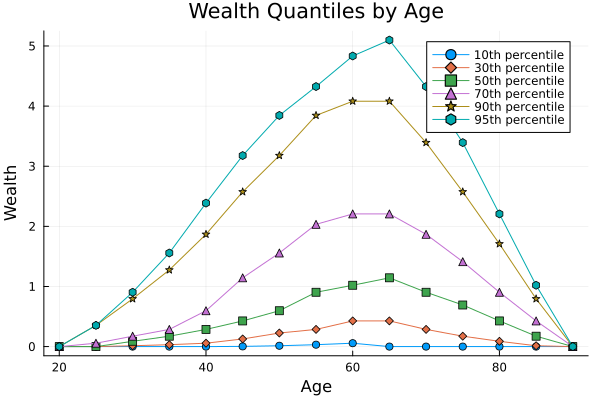

In [28]:
println("Age-Asset Profile for the model with no intergenerational links and unequal (accidental) bequests")
wealth_quantile_age!(params_exp_3, results_exp_3)

Age-Asset Profile for the model with no intergenerational links and equal bequests to all (Figure-1 from the paper)
<center><img src="../figures/figure2.png" style="height:300px"></center>

Age-Asset Profile for the model with one intergenerational link- voluntary bequest and no productivity inheritance


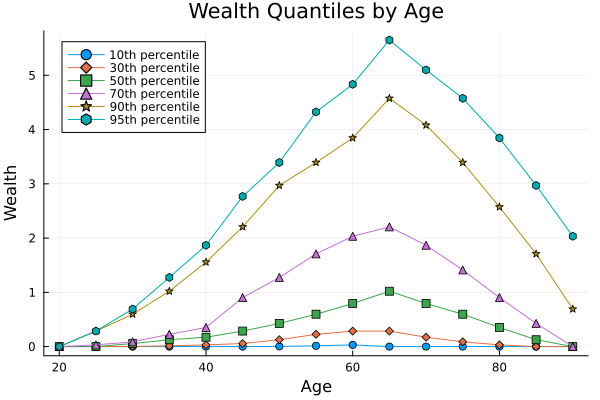

In [29]:
println("Age-Asset Profile for the model with one intergenerational link- voluntary bequest and no productivity inheritance")
wealth_quantile_age!(params_exp_1, results_exp_1)

We present the author's originally reported gigure for comparison (Figure-2 in the paper)
<center><img src="../figures/figure1.png" style="height:300px"></center>

### Runtime Statistics

Below we proivde the time it takes for the code to solve the baseline model (with both intergenerational links) in  different scenarios. This is a computationally intensive model where the bequest distribution needs to converge in equilibrium (the expected bequests that kids are expecting equals the actual bequests left by parents in equilibrium), on top of satisfying the government budget balance (general equilibrium loop). The former is the inner while loop, and the latter forms the outer while loop. 

All the computations were done using a MAC system with an Apple M1 Max silicon chip with 10 cores and 64 gb RAM. I did not try to optimize the code, so most of the computation is done using a single core.


#### Case-1: When we start with the right guess of bequest distribution as well as the labor income tax that satisfies the government budget constraint.
(Since, I solved the model before and saved the objects, I have the luxury to run the above experiment.)

In [30]:
# First let's load the correct bequest distribution from the saved file.
params = params_dict(); # loading parameter dictionary
# @load "output/baseline_model_dict_matched.jld2" results;
beq_dist_right_guess = results[:beqdist];  # bequest dist before smoothing
kercoeff_right_guess = results[:kercoeff];  # bequest dist after smoothing

# Now let's set the τ_l to the equilibrium value τₗˢ = 0.279 (the value that satisfies the budget constraint)
τ_l_right_guess = 0.279;

# Now let's see how much time it takes to run the function with the right guess of both labor income tax and bequest distribution
@time denardi_main(params; τ_l = τ_l_right_guess, beqdist = beq_dist_right_guess, kercoeff = kercoeff_right_guess);

 99.318353 seconds (2.40 G allocations: 60.394 GiB, 5.13% gc time, 3.73% compilation time)


So, it takes approximately 90 seconds if you start with the right guess of bequest distribution and labor tax. 

#### Case-2: When we start with the right guess of bequest distribution only. Note the $\tau_l$ guess is not very far away from the actual value in this experiment.

In [38]:
# First let's load the correct bequest distribution from the saved file.
params = params_dict(); # loading parameter dictionary
# @load "output/baseline_model_dict_matched.jld2" results;
beq_dist_right_guess = results[:beqdist];  # bequest dist before smoothing
kercoeff_right_guess = results[:kercoeff];  # bequest dist after smoothing

τ_l = 0.2823769
# Now let's see how much time it takes to run the function with the right guess of both labor income tax and bequest distribution
@time denardi_main(params; τ_l = τ_l, beqdist = beq_dist_right_guess, kercoeff = kercoeff_right_guess);

181.763018 seconds (4.72 G allocations: 118.239 GiB, 5.03% gc time, 0.00% compilation time)


So, it takes approximately 3 min. (184 seconds) if you start with the right guess of bequest dist only.

#### Case-3: When we start with the right guess of $\tau_l$ which satisfies the government budget constraint. 

In [39]:
# First let's load the correct bequest distribution from the saved file.
params = params_dict(); # loading parameter dictionary
# @load "output/baseline_model_dict_matched.jld2" results;

# Now let's set the τ_l to the equilibrium value τₗˢ = 0.279 (the value that satisfies the budget constraint)
τ_l_right_guess = 0.279;

# Now let's see how much time it takes to run the function with the right guess of both labor income tax and bequest distribution
@time denardi_main(params; τ_l = τ_l_right_guess);

1579.891226 seconds (41.27 G allocations: 1.009 TiB, 5.05% gc time, 0.01% compilation time)


So, it takes approximately 26 min. (1580 seconds) if you start with the right guess of $\tau_l$ only.

#### Case-4: Starting with a random guess for bequest distribution and a plausible guess for $\tau_l$ (from past studies) which is not very close to the equilibrium value.

In [40]:
# First let's load the correct bequest distribution from the saved file.
params = params_dict(); # loading parameter dictionary
# @load "output/baseline_model_dict_matched.jld2" results;

# Now let's set the τ_l to the equilibrium value τₗˢ = 0.279 (the value that satisfies the budget constraint)
τ_l_guess = 0.224; # Taken from past studies (Guvenen et al (2024))

# Now let's see how much time it takes to run the function with the right guess of both labor income tax and bequest distribution
@time denardi_main(params; τ_l = τ_l_guess);

5746.451978 seconds (148.58 G allocations: 3.634 TiB, 5.11% gc time)


It takes approximately 95 min. (5747 seconds) without the right guess either for the bequest distribution or labor income tax.